# Let's see if it's working

In [1]:
import torch
from torch import nn

import matplotlib.pyplot as plt

from nn.sequential import *
from nn.activation import *
from nn.linear import *
from nn.loss import *
from trainer import Trainer

In [2]:
def gen_data(n):
    x = empty((2 * n, 2)).uniform_(0, to=1)
    pi = empty((1)).fill_(0).acos().item() * 2

    target = ((x - empty(1,2).fill_(0.5)).pow(2).sum(dim=1) <= 1/(2*pi)) * 1

    x_train, x_test = x[:n], x[n:]
    y_train, y_test = target[:n], target[n:]
    return x_train, x_test, y_train.view(-1, 1), y_test.view(-1, 1)

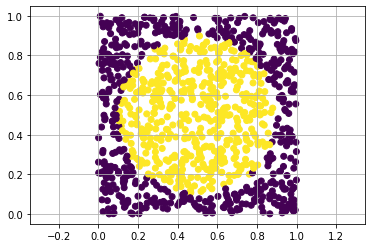

In [3]:
# Create data
x_train, x_test, y_train, y_test = gen_data(1000)

# Plot train data
plt.scatter(x_train.numpy()[:,0], x_train.numpy()[:,1], c=y_train[:, 0])
plt.axis('equal')
plt.grid()
plt.show()

# Our model

In [4]:
def init_model(dim_in, dim_out, dim_hidden, n_hidden=1):
    net = Sequential((
        Linear(dim_in, dim_hidden),
        ReLU(),
        *(Linear(dim_hidden, dim_hidden), ReLU()) * (n_hidden),
        Linear(dim_hidden, dim_out)),
        MSELoss()
    )
    return net

In [5]:
LinNet_ours = init_model(dim_in=2, dim_out=1, dim_hidden=25, n_hidden=3)

LinNet_ours.print()

nb_epochs = 500
t = Trainer(nb_epochs=nb_epochs)
_ = t.fit(LinNet_ours, x_train, y_train, x_test, y_test, batch_size=32, optim='sgd', print_every=int(nb_epochs*0.1), lr=0.01)

Sequential((
Linear(in_features=2, out_features=25, bias=True), 
ReLU(), 
Linear(in_features=25, out_features=25, bias=True), 
ReLU(), 
Linear(in_features=25, out_features=25, bias=True), 
ReLU(), 
Linear(in_features=25, out_features=25, bias=True), 
ReLU(), 
Linear(in_features=25, out_features=1, bias=True), 
))
# Epoch   1/500:	 loss=4.0000e-01	 loss_val=2.6000e-01
# Epoch  51/500:	 loss=2.4000e-01	 loss_val=2.5000e-01
# Epoch 101/500:	 loss=2.4000e-01	 loss_val=2.4000e-01
# Epoch 151/500:	 loss=1.6000e-01	 loss_val=1.7000e-01
# Epoch 201/500:	 loss=8.0000e-02	 loss_val=1.1000e-01
# Epoch 251/500:	 loss=5.0000e-02	 loss_val=6.0000e-02
# Epoch 301/500:	 loss=4.0000e-02	 loss_val=4.0000e-02
# Epoch 351/500:	 loss=5.0000e-02	 loss_val=4.0000e-02
# Epoch 401/500:	 loss=6.0000e-02	 loss_val=4.0000e-02
# Epoch 451/500:	 loss=6.0000e-02	 loss_val=7.0000e-02


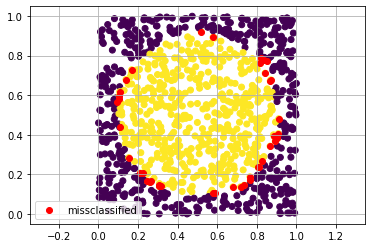

tensor(0.0840)


In [6]:
# Prediction
y_pred = LinNet_ours(x_test).round()

# missclassified points
missclass = (y_pred != y_test).reshape(-1)
x_missclass = x_test[missclass]

# Plot test data
plt.scatter(x_test.numpy()[:,0], x_test.numpy()[:,1], c=y_pred[:, 0])
plt.scatter(x_missclass.numpy()[:,0], x_missclass.numpy()[:,1], c='r', label='missclassified')
plt.axis('equal')
plt.legend()
plt.grid()
plt.show()

print(missclass.sum()/nb_epochs)

# Hyperparameter tuning for our model

In [17]:
### Using SGD only

# Search parameters
n_epochs = 100
n_samples = 1000

# Search grid
lrs = torch.logspace(start=-1, end=-2, steps=5)
batch_sizes = torch.Tensor([16, 32, 64]).int()

x_train, x_test, y_train, y_test = gen_data(n_samples)

best_test_error = 1
best_lr = -1
best_bs = -1
for lr in lrs:
    for bs in batch_sizes:
        print(f"# Lr={lr}, bs={bs}")
        LinNet = init_model(dim_in=2, dim_out=1, dim_hidden=25, n_hidden=3)

        t = Trainer(nb_epochs=nb_epochs)
        _ = t.fit(LinNet, x_train, y_train, x_test, y_test, batch_size=bs, optim='sgd', verbose=False, lr=lr)

        y_test_pred = LinNet(x_test).round()
        test_error = (y_test_pred != y_test).sum() / n_samples

        if test_error < best_test_error:
            best_test_error = test_error
            best_lr = lr
            best_bs = bs

print(f"\nBest learning: {best_lr}    Best batch_size: {best_bs}")
print(f"Best test error: {best_test_error}")

# Lr=0.10000000149011612, bs=16
# Lr=0.10000000149011612, bs=32
# Lr=0.10000000149011612, bs=64
# Lr=0.05623413249850273, bs=16
# Lr=0.05623413249850273, bs=32
# Lr=0.05623413249850273, bs=64
# Lr=0.03162277489900589, bs=16
# Lr=0.03162277489900589, bs=32
# Lr=0.03162277489900589, bs=64
# Lr=0.017782794311642647, bs=16
# Lr=0.017782794311642647, bs=32
# Lr=0.017782794311642647, bs=64
# Lr=0.009999999776482582, bs=16
# Lr=0.009999999776482582, bs=32
# Lr=0.009999999776482582, bs=64

Best learning: 0.017782794311642647    Best batch_size: 32
Best test error: 0.024000000208616257
